# Airline Reviews Air-France
https://www.airlinequality.com/airline-reviews/air-france

In [24]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
# from gensim.models import CoherenceModel
# import gensim.corpora as Corpora
import re
from tqdm.notebook import tqdm
import time

from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.chrome.options import Options


import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import  cosine_similarity
from sklearn.model_selection  import train_test_split

from sklearn.decomposition import LatentDirichletAllocation
from textblob import TextBlob

import warnings

warnings.filterwarnings('ignore')

# Data Extraction

In [25]:
def scrape_reviews(base_url, num_pages=10):
    # Initialize the Selenium WebDriver
    driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()))

    all_reviews = []

    for page_number in range(1, num_pages + 1):
        print(f"Scraping page {page_number}...")

        # Construct URL for the current page
        url = f"{base_url}/page/{page_number}/"
        driver.get(url)
        
        # Wait for the page to load completely
        time.sleep(5)

        # Get the page source
        html_content = driver.page_source

        # Parse the HTML content using BeautifulSoup
        soup = BeautifulSoup(html_content, 'html.parser')

        # Extract reviews
        for article in soup.find_all('article', itemprop='review'):
            try:
                date_published = article.find('meta', itemprop='datePublished')['content']
                rating_value = article.find('span', itemprop='ratingValue').text
                best_rating = article.find('span', itemprop='bestRating').text
                author_name = article.find('span', itemprop='name').text
                review_body = article.find('div', itemprop='reviewBody').text.strip()

                # Extract ratings for different categories
                ratings = {}
                for row in article.select('table.review-ratings tr'):
                    key = row.find('td', class_='review-rating-header').text.strip()
                    value = row.find('td', class_='review-value')
                    if value:
                        ratings[key] = value.text.strip()
                    else:
                        # Extract stars for categories with stars instead of text
                        stars = len(row.find_all('span', class_='star fill'))
                        ratings[key] = stars

                # Extract recommendation
                recommended = article.select_one('td.review-value.rating-no')
                recommended = 'No' if recommended else 'Yes'

                # Append data to the list
                all_reviews.append({
                    'Date Published': date_published,
                    'Rating': int(rating_value),
                    'Best Rating': int(best_rating),
                    'Author': author_name,
                    'Review': review_body,
                    **ratings,
                    'Recommended': recommended
                })
            except Exception as e:
                print(f"Error extracting review: {e}")
                continue

    # Close the WebDriver
    driver.quit()

    return all_reviews

# Base URL of the British Airways reviews page
base_url = 'https://www.airlinequality.com/airline-reviews/air-france'

# Scrape reviews from all pages
reviews = scrape_reviews(base_url, num_pages=10)

# Convert the list to a DataFrame
df = pd.DataFrame(reviews)

# Save the DataFrame to a CSV file (optional)
df.to_csv('./data/KQ_reviews.csv', index=False)

Scraping page 1...
Scraping page 2...
Scraping page 3...
Scraping page 4...
Scraping page 5...
Scraping page 6...
Scraping page 7...
Scraping page 8...
Scraping page 9...
Scraping page 10...


## Data Cleaning

In [26]:
# Load the Dataset
df = pd.read_csv("./data/KQ_reviews.csv")
df.head()

,Date Published,Rating,Best Rating,Author,Review,Type Of Traveller,Seat Type,Route,Date Flown,Seat Comfort,Cabin Staff Service,Food & Beverages,Inflight Entertainment,Ground Service,Wifi & Connectivity,Value For Money,Recommended,Aircraft
0,2025-09-10,4,10,N Jawan,✅ Trip Verified | Houston to Mumbai via Pari...,Solo Leisure,Economy Class,Mumbai to Houston via Kolkata,September 2025,2.0,2.0,1.0,3.0,1.0,1.0,2,No,NaN
1,2025-09-09,9,10,Andrew McDougall,✅ Trip Verified | The flight from LHR to CDG ...,Solo Leisure,Business Class,London to Lima via Paris,September 2025,5.0,5.0,4.0,5.0,5.0,4.0,5,Yes,Airbus A220-300 / Boeing 777-200
2,2025-09-03,1,10,David Rivero Lopez,✅ Trip Verified | I have been a Flying Blue m...,Solo Leisure,Economy Class,Madrid to Lagos via Paris,August 2025,NaN,NaN,NaN,NaN,NaN,NaN,1,No,Boeing 777
3,2025-09-02,10,10,Mikheil Tushishvili,✅ Trip Verified | I had a short flight Veron...,Solo Leisure,Economy Class,Verona to Paris,August 2025,4.0,5.0,5.0,NaN,4.0,NaN,5,Yes,E-170
4,2025-08-31,2,10,Anton Lapatsin,"✅ Trip Verified | Usually ok airline, if eve...",Solo Leisure,Economy Class,Vienna to Paris CDG,July 2025,3.0,4.0,3.0,NaN,4.0,NaN,1,No,NaN


In [27]:
# Check for missing Values
df.isnull().sum()

Date Published             0
Rating                     0
Best Rating                0
Author                     0
Review                     0
Type Of Traveller          0
Seat Type                  0
Route                      1
Date Flown                 0
Seat Comfort               7
Cabin Staff Service        7
Food & Beverages          15
Inflight Entertainment    34
Ground Service             1
Wifi & Connectivity       52
Value For Money            0
Recommended                0
Aircraft                  52
dtype: int64

In [28]:
# Fill the NaN columns with 0
df.fillna(0, inplace=True)

In [29]:
df.head()

,Date Published,Rating,Best Rating,Author,Review,Type Of Traveller,Seat Type,Route,Date Flown,Seat Comfort,Cabin Staff Service,Food & Beverages,Inflight Entertainment,Ground Service,Wifi & Connectivity,Value For Money,Recommended,Aircraft
0,2025-09-10,4,10,N Jawan,✅ Trip Verified | Houston to Mumbai via Pari...,Solo Leisure,Economy Class,Mumbai to Houston via Kolkata,September 2025,2.0,2.0,1.0,3.0,1.0,1.0,2,No,0
1,2025-09-09,9,10,Andrew McDougall,✅ Trip Verified | The flight from LHR to CDG ...,Solo Leisure,Business Class,London to Lima via Paris,September 2025,5.0,5.0,4.0,5.0,5.0,4.0,5,Yes,Airbus A220-300 / Boeing 777-200
2,2025-09-03,1,10,David Rivero Lopez,✅ Trip Verified | I have been a Flying Blue m...,Solo Leisure,Economy Class,Madrid to Lagos via Paris,August 2025,0.0,0.0,0.0,0.0,0.0,0.0,1,No,Boeing 777
3,2025-09-02,10,10,Mikheil Tushishvili,✅ Trip Verified | I had a short flight Veron...,Solo Leisure,Economy Class,Verona to Paris,August 2025,4.0,5.0,5.0,0.0,4.0,0.0,5,Yes,E-170
4,2025-08-31,2,10,Anton Lapatsin,"✅ Trip Verified | Usually ok airline, if eve...",Solo Leisure,Economy Class,Vienna to Paris CDG,July 2025,3.0,4.0,3.0,0.0,4.0,0.0,1,No,0


In [30]:
# Begin data cleaning
def clean_text(text):
    # Remove any unwanted characters
    text = re.sub(r'\n', '', text)  # Remove newlines
    text = re.sub(r'\s+', ' ', text)  # Replace multiple spaces with a single space
    text = re.sub(r'✅ Trip Verified |', '', text)  # Remove specific phrases
    text = text.lower()  # Convert to lowercase
    return text.strip()

df['Cleaned_Review'] = df['Review'].apply(clean_text)


# Sentiment Analysis

In [31]:
# Perform Sentiment Analysis
def get_sentiment(text):
    analysis = TextBlob(text)
    return analysis.sentiment.polarity

df['Sentiment'] = df['Cleaned_Review'].apply(get_sentiment)


In [32]:
# Categorize sentiment into Positive, Neutral, Negative
df['Sentiment_Category'] = df['Sentiment'].apply(lambda x: 'Positive' if x > 0 else ('Negative' if x < 0 else 'Neutral'))


# Topic Modeling

In [33]:
vectorizer = CountVectorizer(stop_words='english', max_df=0.9, min_df=2)
X = vectorizer.fit_transform(df['Cleaned_Review'])

lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(X)

# Display the top words for each topic
for index, topic in enumerate(lda.components_):
    print(f"Top 10 words for topic #{index}:")
    print([vectorizer.get_feature_names_out()[i] for i in topic.argsort()[-10:]])

# Step 4: Word Cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(df['Cleaned_Review']))

Top 10 words for topic #0:
['connection', 'did', 'flying', 'je', 'staff', 'flight', 'et', 'france', 'air', 'le']
Top 10 words for topic #1:
['food', 'business', 'paris', 'class', 'luggage', 'service', 'seat', 'flight', 'air', 'france']
Top 10 words for topic #2:
['comfortable', 'verified', 'pleasant', 'flight', 'food', 'cabin', 'seat', 'good', 'cdg', 'crew']
Top 10 words for topic #3:
['paris', 'day', 'told', 'airport', 'staff', 'af', 'airline', 'flight', 'france', 'air']
Top 10 words for topic #4:
['hour', 'airport', 'luggage', 'time', 'hours', 'service', 'paris', 'france', 'air', 'flight']


In [34]:
data = df.Review

In [35]:
data.values[50]

'✅ Trip Verified |   Flight from Copenhagen was scheduled to depart 12:05. The flight was delayed and after the original departure time, a new departure time was announced to be 13:40 and thereafter changed a second time to 15:00. The flight was in fact delayed even further and departed from Copenhagen 16:52, and thus well over 3 hours delay. I contacted Air France referring to Directive No. 261/2004 , giving a passenger the right to a compensation of at least € 250. Air France first argued that the flight was not delayed beyond 3 hours. I then sent a copy of my physical boarding card clearly showing a departure time of 12:05. Air France then argued that they would not change their decision of refusing any compensation and that their decision was in line "with company policies" without outlining what those policies state. Not even when I requested an explanation why the EU-directive would be applicable, Air France even bothered to detail anything about it. It also deserves to be mentio

# Word Cloud

In [36]:
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(df['Cleaned_Review']))

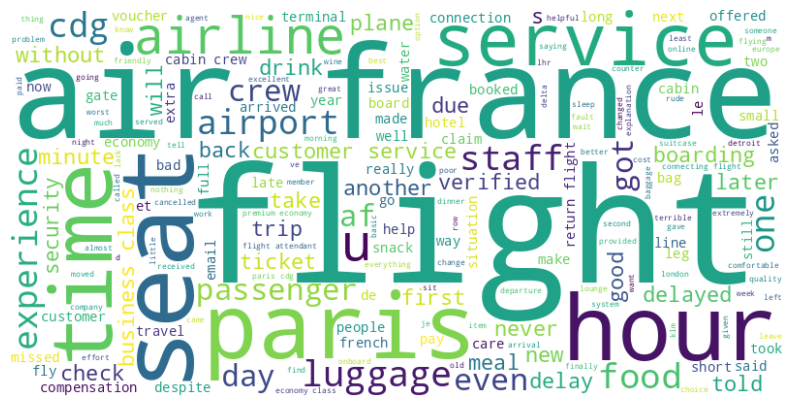

In [37]:
#plot the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

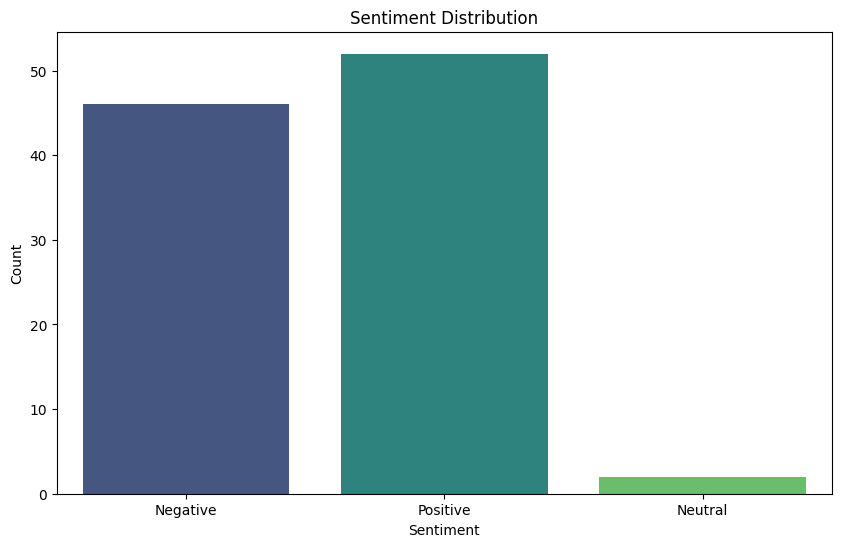

In [38]:
# Sentiment Distribution Plot
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='Sentiment_Category', palette='viridis')
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()


## Analyze by Rating

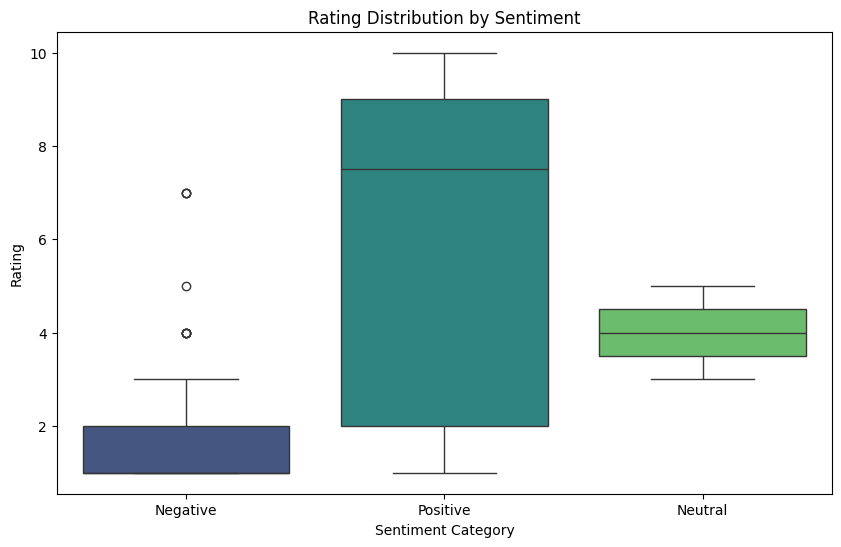

In [39]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='Sentiment_Category', y='Rating', palette='viridis')
plt.title('Rating Distribution by Sentiment')
plt.xlabel('Sentiment Category')
plt.ylabel('Rating')
plt.show()